# RAMP on predicting cyclist traffic in Paris


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head().to_csv("train_data_head.csv")

We can check general information about different columns:

and in particular the number of unique entries in each column,

In [5]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [6]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [7]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

c:\Users\ibrah\anaconda3\Lib\site-packages\folium\utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

<Axes: xlabel='date'>

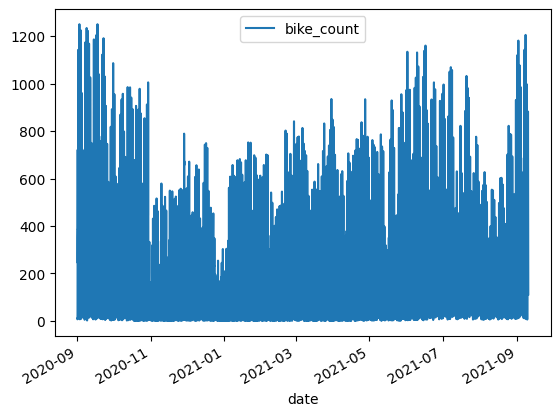

In [8]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

<Axes: xlabel='date'>

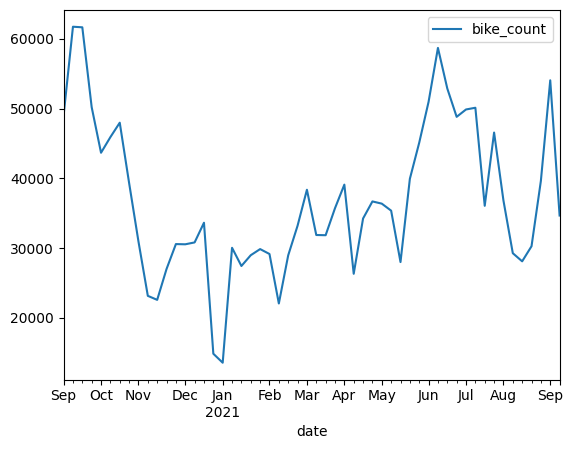

In [9]:
mask = (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")

data[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<Axes: xlabel='date'>

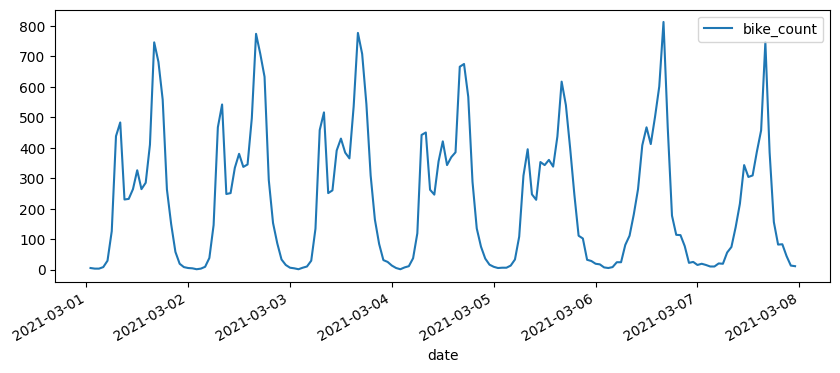

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

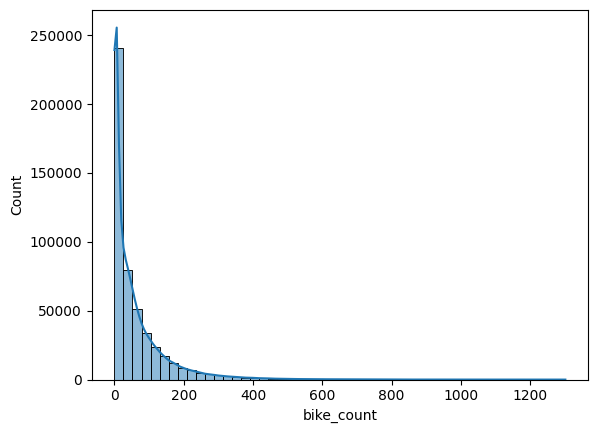

In [11]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

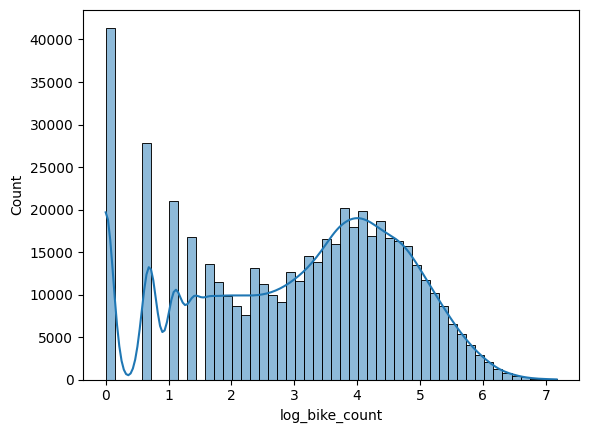

In [12]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

# External data


In [13]:
external_data  = pd.read_csv("./data/external_data.csv",date_parser=["date"])


C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\3089716539.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  external_data  = pd.read_csv("./data/external_data.csv",date_parser=["date"])


In [14]:
def process_weather_data(df):
    """Process weather data to create meaningful features.
    
    Args:
        df: DataFrame containing weather data with columns:
            - t: temperature
            - ff: wind speed
            - rr1: rainfall
            - vv: visibility
            - u: humidity
    
    Returns:
        DataFrame with processed weather features
    """
    df = df.copy()
    
    # Temperature features (Celsius)
    df['temp_celsius'] = df['t']
    df['is_cold'] = (df['temp_celsius'] < 10).astype(int)  # Below 10°C
    df['is_hot'] = (df['temp_celsius'] > 25).astype(int)   # Above 25°C
    
    # Wind features (km/h)
    df['high_wind'] = (df['ff'] > 20).astype(int)  # Above 20 km/h
    
    # Rain features (mm)
    df['is_raining'] = (df['rr1'] > 0).astype(int)
    df['heavy_rain'] = (df['rr1'] > 5).astype(int)  # More than 5mm is heavy rain
    
    # Visibility and humidity
    df['poor_visibility'] = (df['vv'] < 10).astype(int)  # Less than 10km visibility
    df['high_humidity'] = (df['u'] > 80).astype(int)     # More than 80% humidity
    
    return df

In [15]:
external_data_transformed = process_weather_data(external_data)

cols_to_keep = ['date', 'temp_celsius', 'is_cold', 'is_hot', 'high_wind', 'is_raining', 'heavy_rain', 'poor_visibility', 'high_humidity']
weather_df = external_data_transformed[cols_to_keep]

weather_df.head()

,date,temp_celsius,is_cold,is_hot,high_wind,is_raining,heavy_rain,poor_visibility,high_humidity
0,2021-01-01 00:00:00,272.75,0,1,0,0,0,0,1
1,2021-01-01 03:00:00,271.25,0,1,0,0,0,0,1
2,2021-01-01 06:00:00,271.95,0,1,0,0,0,0,1
3,2021-01-01 09:00:00,272.45,0,1,0,0,0,0,1
4,2021-01-01 12:00:00,276.95,0,1,0,0,0,0,1


In [16]:
def merge_with_weather(X, weather_df):
    """Merge input data with weather data based on timestamp.
    
    Args:
        X: Input DataFrame with 'date' column
        weather_df: Weather DataFrame with 'date' column
    
    Returns:
        Merged DataFrame with weather features
    """
    # Ensure datetime format
    X = X.copy()
    weather_df = weather_df.copy()
    
    # X['date'] = pd.to_datetime(X['date'])
    # weather_df['date'] = pd.to_datetime(weather_df['date'])
    
    # Convert to same precision to avoid merge issues
    X['date'] = X['date'].astype('datetime64[us]')
    weather_df['date'] = weather_df['date'].astype('datetime64[us]')
    
    # Add index for preserving order
    X['orig_index'] = np.arange(X.shape[0])
    
    # Merge data using nearest timestamp
    merged_df = pd.merge_asof(
        X.sort_values('date'),
        weather_df.sort_values('date'),
        on='date',
        direction='nearest'
    )
    
    # Restore original order and drop index
    merged_df = merged_df.sort_values('orig_index')
    merged_df = merged_df.drop('orig_index', axis=1)
    
    return merged_df

In [17]:
merged_df = merge_with_weather(data, weather_df)

merged_df.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count',
       'temp_celsius', 'is_cold', 'is_hot', 'high_wind', 'is_raining',
       'heavy_rain', 'poor_visibility', 'high_humidity'],
      dtype='object')

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [18]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [19]:
merged_df["date"].head()

107   2020-09-01 02:00:00
153   2020-09-01 03:00:00
201   2020-09-01 04:00:00
782   2020-09-01 15:00:00
925   2020-09-01 18:00:00
Name: date, dtype: datetime64[us]

In [20]:
_encode_dates(merged_df[["date"]].head())

,year,month,day,weekday,hour
107,2020,9,1,1,2
153,2020,9,1,1,3
201,2020,9,1,1,4
782,2020,9,1,1,15
925,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html):

In [21]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(merged_df[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
107,2020,9,1,1,2
153,2020,9,1,1,3
201,2020,9,1,1,4
782,2020,9,1,1,15
925,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [22]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [23]:
def get_feature_target(data, target_column_name):
    # Sort by date first, so that time based cross-validation would produce correct results
    data = data.sort_values(["date", "counter_name"])
    y_array = data[target_column_name].values
    X_df = data.drop([target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [24]:
X, y = get_feature_target(merged_df, "log_bike_count")

and

In [25]:
y

array([1.60943791, 1.38629436, 0.        , ..., 3.49650756, 2.30258509,
       2.07944154])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [26]:
# Let's try to add distance to Paris center
from math import radians, sin, cos, sqrt, atan2
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Paris center coordinates (approximate)
PARIS_CENTER_LAT = 48.8566
PARIS_CENTER_LON = 2.3522
X['distance_to_center'] = X.apply(lambda row: haversine_distance(
    row['latitude'], row['longitude'], 
    PARIS_CENTER_LAT, PARIS_CENTER_LON
), axis=1)

In [27]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [28]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [29]:

X_train.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'date',
       'counter_installation_date', 'coordinates', 'counter_technical_id',
       'latitude', 'longitude', 'temp_celsius', 'is_cold', 'is_hot',
       'high_wind', 'is_raining', 'heavy_rain', 'poor_visibility',
       'high_humidity', 'distance_to_center'],
      dtype='object')

In [30]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year', 'month', 'day', 'weekday', 'hour']

In [31]:
cols_to_drop = ['counter_id', 'site_id', 'counter_technical_id', 'coordinates', 'counter_installation_date']

X_train = X_train.drop(cols_to_drop, axis=1)
X_valid = X_valid.drop(cols_to_drop, axis=1)

In [32]:
X_train.head()

,counter_name,site_name,date,latitude,longitude,temp_celsius,is_cold,is_hot,high_wind,is_raining,heavy_rain,poor_visibility,high_humidity,distance_to_center
20,152 boulevard du Montparnasse E-O,152 boulevard du Montparnasse,2020-09-01 01:00:00,48.840801,2.333233,285.75,0,1,0,0,0,0,1,2.238830
8,152 boulevard du Montparnasse O-E,152 boulevard du Montparnasse,2020-09-01 01:00:00,48.840801,2.333233,285.75,0,1,0,0,0,0,1,2.238830
44,18 quai de l'Hôtel de Ville NO-SE,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,48.853720,2.357020,285.75,0,1,0,0,0,0,1,0.476352
43,18 quai de l'Hôtel de Ville SE-NO,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,48.853720,2.357020,285.75,0,1,0,0,0,0,1,0.476352
34,20 Avenue de Clichy NO-SE,20 Avenue de Clichy,2020-09-01 01:00:00,48.885290,2.326660,285.75,0,1,0,0,0,0,1,3.696837


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor1 = Ridge()

pipe1 = make_pipeline(date_encoder, preprocessor, regressor1)
pipe1.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000023F20D9A0C0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [34]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe1.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe1.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.73


c:\Users\ibrah\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ibrah\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

  

regressor =XGBRegressor()


pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000023F20D9A0C0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('xgbregressor',
                 XGBR...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [37]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.52
Valid set, RMSE=0.54


c:\Users\ibrah\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ibrah\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [38]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


c:\Users\ibrah\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ibrah\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

Text(0, 0.5, 'bike_count')

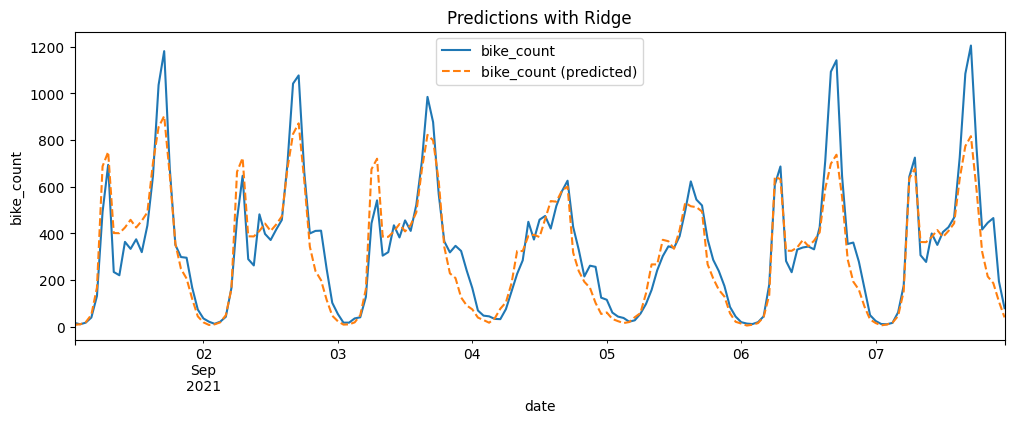

In [39]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1


fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

Text(0, 0.5, 'bike_count')

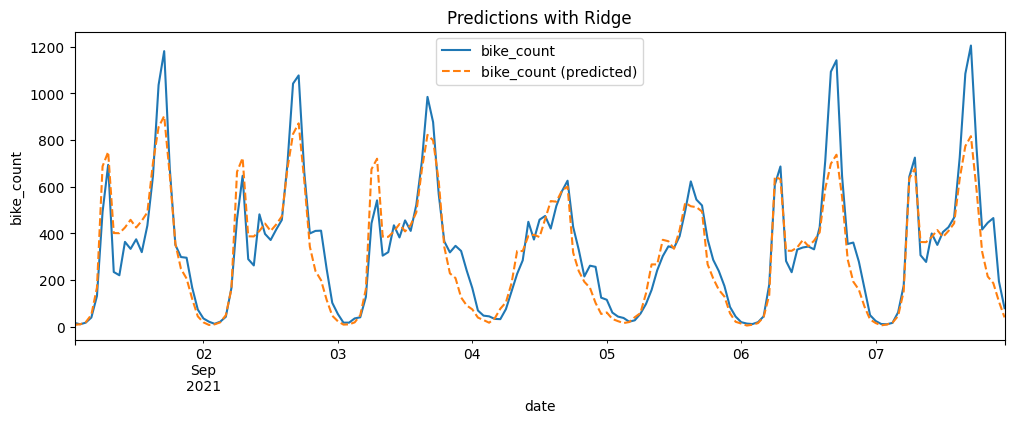

In [40]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<Axes: xlabel='y_true', ylabel='y_pred'>

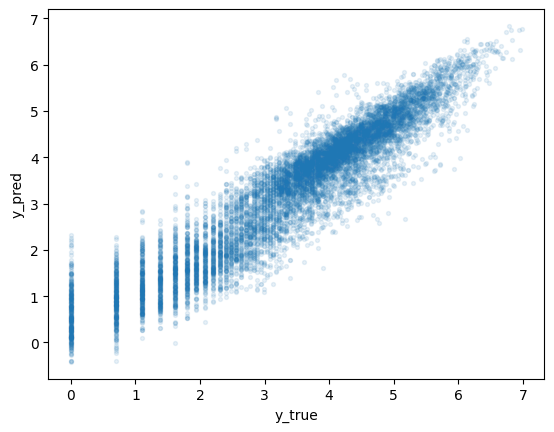

In [41]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [42]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.82384261 -0.80560472 -0.74373695 -0.79812733 -0.9029749  -0.88309978]
RMSE (all folds): 0.826 ± 0.0535


In [43]:
# playground

from xgboost import XGBRegressor


xgb = XGBRegressor()
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

# Feature engineering


In [44]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    # external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')


    
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]


     # Select relevant weather features
    relevant_weather_cols = ['date',
        't', 'tx12', 'tx24', 'tn12', 'tn24',  # Temperature
        'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol',  # Precipitation & Conditions
        'ff', 'raf10', 'dd',  # Wind
        'vv', 'n', 'u',  # Visibility & Humidity
        'pmer', 'tend'  # Pressure
    ]
    weather_df = weather_data[relevant_weather_cols + cols_to_keep]

    # # 1. Rainfall features - forward fill then backward fill, finally fill with 0
    # rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
    # weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
    # # 2. Snow and ground condition - forward fill then most frequent
    # weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
    # weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
        
    # # 3. Wind gust - simple regression based on wind speed
    # if weather_data['raf10'].isnull().any():
    #     from sklearn.linear_model import LinearRegression
    #     mask = ~weather_data['raf10'].isnull()
    #     reg = LinearRegression().fit(
    #             weather_data.loc[mask, ['ff']], 
    #             weather_data.loc[mask, 'raf10']
    #         )
    #     weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
        
    # # 4. Cloud cover - forward fill then backward fill
    # weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
        
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
        
    # Merge with weather data
    X = pd.merge_asof(
            X.sort_values("date"),
            weather_df.sort_values("date"),
            on="date",
            direction="nearest"
        )
    
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X
df_train = pd.read_parquet("data/train.parquet")


df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

In [45]:
weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])

weather_data.columns


Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch',
       'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24',
       'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4'],
      dtype='object')

In [46]:
weather_data.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [48]:
weather_data['numer_sta'].nunique()

1

In [50]:
# Handle missing values
# 1. Rainfall features - forward fill then backward fill, finally fill with 0
rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
    
# 2. Snow and ground condition - forward fill then most frequent
weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
    
# 3. Wind gust - simple regression based on wind speed
if weather_data['raf10'].isnull().any():
    from sklearn.linear_model import LinearRegression
    mask = ~weather_data['raf10'].isnull()
    reg = LinearRegression().fit(
            weather_data.loc[mask, ['ff']], 
            weather_data.loc[mask, 'raf10']
        )
    weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
    
# 4. Cloud cover - forward fill then backward fill
weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
    

C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\219464772.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\219464772.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\219464772.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\219464772.py:21: FutureWarning: Ser

In [9]:
weather_data.isna().sum()

counter_id                        0
counter_name                      0
site_id                           0
site_name                         0
bike_count                        0
date                              0
counter_installation_date         0
coordinates                       0
counter_technical_id              0
latitude                          0
longitude                         0
log_bike_count                    0
t                                 0
tx12                         372878
tx24                         496827
tn12                         372878
tn24                         496827
rr1                               0
rr3                               0
rr6                               0
rr12                              0
rr24                              0
ww                                0
ht_neige                          0
etat_sol                          0
ff                                0
raf10                             0
dd                          

In [53]:
data_merged = _merge_external_data(df_train)

final_df = _encode_dates(data_merged)

final_target = final_df[['log_bike_count']]

final_features = final_df.drop(['tx12','tx24', 'tn12', 'tn24', 'counter_id', 'site_id', 'bike_count','log_bike_count', 'counter_installation_date',
             'coordinates', 'counter_technical_id'
            ], axis=1)

final_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 107 to 496826
Data columns (total 42 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   counter_name     496827 non-null  category
 1   site_name        496827 non-null  category
 2   latitude         496827 non-null  float64 
 3   longitude        496827 non-null  float64 
 4   t                496827 non-null  float64 
 5   rr1              495483 non-null  float64 
 6   rr3              496155 non-null  float64 
 7   rr6              494823 non-null  float64 
 8   rr12             494151 non-null  float64 
 9   rr24             493815 non-null  float64 
 10  ww               496827 non-null  int64   
 11  ht_neige         489475 non-null  float64 
 12  etat_sol         488679 non-null  float64 
 13  ff               496827 non-null  float64 
 14  raf10            495159 non-null  float64 
 15  dd               496827 non-null  int64   
 16  vv               496827

In [54]:
# Feature selection
date_cols = ['year', 'month', 'day', 'weekday', 'hour']

numeric_cols = final_features.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
numeric_cols = list(set(numeric_cols) - set(date_cols))


categorical_cols = final_features.select_dtypes(include=['category']).columns.tolist() +date_cols


In [55]:
print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))
print("Columns in final_features:", len(final_features.columns.tolist()))

Numeric columns: 34
Categorical columns: 8
Columns in final_features: 42


In [56]:
numeric_cols

['is_hot',
 'temp_celsius',
 'hour_sin',
 'high_wind',
 'heavy_rain',
 'high_humidity',
 'is_raining',
 'rr6',
 'rr3',
 'n',
 'is_working_hour',
 'ww',
 'u',
 'is_cold',
 'rr1',
 'month_sin',
 'is_rush_hour',
 'ht_neige',
 'latitude',
 'rr24',
 'ff',
 'dd',
 't',
 'rr12',
 'raf10',
 'vv',
 'poor_visibility',
 'etat_sol',
 'is_weekend',
 'longitude',
 'tend',
 'month_cos',
 'pmer',
 'hour_cos']

In [57]:
categorical_cols

['counter_name',
 'site_name',
 'season',
 'year',
 'month',
 'day',
 'weekday',
 'hour']

In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel


preprocessor_regression = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), numeric_cols),
        ("categorical", OneHotEncoder(), categorical_cols),
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("numeric", "passthrough", numeric_cols),
        ("categorical", OneHotEncoder(), categorical_cols),
    ]
)


In [59]:
X_tranformed = preprocessor_tree.fit_transform(final_features)


In [60]:
X_final = X_tranformed.toarray()

In [61]:
X_final

array([[ 0.        , 10.8       ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 10.8       ,  0.70710678, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 10.8       ,  0.8660254 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        , 26.2       , -0.70710678, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 19.1       , -0.5       , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , 18.3       , -0.25881905, ...,  0.        ,
         0.        ,  1.        ]])

In [62]:
len(preprocessor_tree.get_feature_names_out().tolist())

200

In [63]:
X_df = pd.DataFrame(X_final, columns=preprocessor_tree.get_feature_names_out().tolist()) 

In [64]:
X_df

,numeric__is_hot,numeric__temp_celsius,numeric__hour_sin,numeric__high_wind,numeric__heavy_rain,numeric__high_humidity,numeric__is_raining,numeric__rr6,numeric__rr3,numeric__n,...,categorical__hour_14,categorical__hour_15,categorical__hour_16,categorical__hour_17,categorical__hour_18,categorical__hour_19,categorical__hour_20,categorical__hour_21,categorical__hour_22,categorical__hour_23
0,0.0,10.8,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,10.8,0.707107,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,10.8,0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,20.5,-0.707107,0.0,0.0,0.0,0.0,0.0,0.0,60.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,19.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496822,0.0,19.7,1.000000,0.0,0.0,1.0,0.0,-0.1,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496823,0.0,20.3,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496824,1.0,26.2,-0.707107,0.0,0.0,0.0,0.0,0.0,0.0,75.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496825,0.0,19.1,-0.500000,0.0,0.0,1.0,0.0,0.6,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
preprocessor_tree.get_feature_names_out()

array(['numeric__ht_neige', 'numeric__is_raining', 'numeric__latitude',
       'numeric__heavy_rain', 'numeric__vv', 'numeric__n', 'numeric__u',
       'numeric__dd', 'numeric__rr3', 'numeric__t', 'numeric__rr24',
       'numeric__ff', 'numeric__poor_visibility',
       'numeric__is_working_hour', 'numeric__high_humidity',
       'numeric__hour_sin', 'numeric__distance_to_center',
       'numeric__hour_cos', 'numeric__rr6', 'numeric__longitude',
       'numeric__rr1', 'numeric__etat_sol', 'numeric__high_wind',
       'numeric__month_cos', 'numeric__is_rush_hour', 'numeric__rr12',
       'numeric__is_weekend', 'numeric__temp_celsius', 'numeric__is_cold',
       'numeric__month_sin', 'numeric__is_hot', 'numeric__ww',
       'numeric__raf10', 'numeric__tend', 'numeric__pmer',
       'categorical__counter_name_152 boulevard du Montparnasse E-O',
       'categorical__counter_name_152 boulevard du Montparnasse O-E',
       "categorical__counter_name_18 quai de l'Hôtel de Ville NO-SE",
      

In [33]:
#Lasso feature selection
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
import pandas as pd

# Sample data preparation (assuming 'final_features' and 'target' are defined)
# Here, `final_features` is the dataset and `target` is the dependent variable (Y).
# For demonstration, I'll create a mock dataset if required.

# Apply preprocessor for regression (with scaling and encoding)
X_transformed = preprocessor_regression.fit_transform(final_features)

# Convert transformed data to a DataFrame for feature alignment
feature_names = preprocessor_regression.get_feature_names_out().tolist()
feature_names = np.array(feature_names)
X_transformed_df = pd.DataFrame(X_transformed.toarray(), columns=feature_names)

# Target variable (assuming defined as 'target')
y = final_df[['log_bike_count']].values

# 1. Feature Selection with LassoCV
lasso = LassoCV(cv=3).fit(X_transformed_df, y)
lasso_selector = SelectFromModel(lasso, prefit=True)
selected_features_lasso = feature_names[lasso_selector.get_support()]

# Compile results into a DataFrame for analysis
selection_results = pd.DataFrame({
    "Feature": feature_names,
    "Lasso_Selected": lasso_selector.get_support()
})

# Display selected features
selected_features = {
    "Lasso_Selected": selected_features_lasso.tolist(),
}

selected_features = pd.DataFrame(selected_features)



c:\Users\ibrah\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
selection_results

,Feature,Lasso_Selected
0,numeric__ht_neige,True
1,numeric__is_raining,True
2,numeric__latitude,True
3,numeric__heavy_rain,True
4,numeric__vv,True
...,...,...
196,categorical__hour_19,True
197,categorical__hour_20,True
198,categorical__hour_21,True
199,categorical__hour_22,False


In [36]:
selected_features['Lasso_Selected'].unique()

array(['numeric__ht_neige', 'numeric__is_raining', 'numeric__latitude',
       'numeric__heavy_rain', 'numeric__vv', 'numeric__n', 'numeric__u',
       'numeric__dd', 'numeric__rr3', 'numeric__t', 'numeric__rr24',
       'numeric__poor_visibility', 'numeric__high_humidity',
       'numeric__hour_sin', 'numeric__distance_to_center',
       'numeric__hour_cos', 'numeric__longitude', 'numeric__rr1',
       'numeric__etat_sol', 'numeric__month_cos', 'numeric__is_rush_hour',
       'numeric__rr12', 'numeric__is_weekend', 'numeric__temp_celsius',
       'numeric__is_cold', 'numeric__month_sin', 'numeric__is_hot',
       'numeric__ww', 'numeric__raf10', 'numeric__tend', 'numeric__pmer',
       'categorical__counter_name_152 boulevard du Montparnasse O-E',
       "categorical__counter_name_18 quai de l'Hôtel de Ville NO-SE",
       'categorical__counter_name_254 rue de Vaugirard SO-NE',
       'categorical__counter_name_27 quai de la Tournelle SE-NO',
       'categorical__counter_name_28 boule

In [ ]:
# Let's select training our best xgboost model

# let's check the feature engin

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# MODEL 11

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score


# Custom OneHotEncoder to generate feature names with double underscores
class CustomOneHotEncoder(OneHotEncoder):
    def get_feature_names_out(self, input_features=None):
        """Override method to include double underscore separator in a robust way."""
        if input_features is None:
            input_features = self.feature_names_in_
        
        categories = self.categories_
        feature_names = []
        for feature, cats in zip(input_features, categories):
            feature_names.extend([f"{feature}__{cat}" for cat in cats])
        return np.array(feature_names)

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True) 
    
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([6,7,8,9]) | X["hour"].isin([16,17,18]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    # external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')


    
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]


     # Select relevant weather features
    relevant_weather_cols = ['date',
        'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol',  # Precipitation & Conditions
        'ff', 'raf10', 'dd',  # Wind
        'vv', 'n', 'u',  # Visibility & Humidity
        'pmer', 'tend'  # Pressure
    ]
    weather_df = weather_data[relevant_weather_cols + cols_to_keep]

    # Missing value handling
    # 1. Rainfall features - forward fill then backward fill, finally fill with 0
    rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
    weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
    # 2. Snow and ground condition - forward fill then most frequent
    weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
    weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
        
    # 3. Wind gust - simple regression based on wind speed
    if weather_data['raf10'].isnull().any():
        from sklearn.linear_model import LinearRegression
        mask = ~weather_data['raf10'].isnull()
        reg = LinearRegression().fit(
                weather_data.loc[mask, ['ff']], 
                weather_data.loc[mask, 'raf10']
            )
        weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
        
    # 4. Cloud cover - forward fill then backward fill
    weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
        
        # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
        
    # Merge with weather data
    X = pd.merge_asof(
            X.sort_values("date"),
            weather_df.sort_values("date"),
            on="date",
            direction="nearest"
        )
        
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)
    return X


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid

def get_estimator(train_data):
    """Create and return the full prediction pipeline."""
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)
    
    X_transformed = _merge_external_data(X_train)
    X_transformed = _add_location_features(X_transformed)
    X_transformed = _encode_dates(X_transformed)

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]

    all_cols = list(X_transformed.columns)

    other_cols = list(set(all_cols) - set(date_cols) -set(categorical_cols))

    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", CustomOneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", CustomOneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("other", "passthrough", other_cols)
        ]
    )
    
    # Create XGBoost with best hyperparameters
    xgb_model = XGBRegressor(
                colsample_bytree=0.9329770563201687,
                gamma=0.10616955533913808,
                learning_rate=0.06454749016213018,
                max_depth=7,
                min_child_weight=1,
                n_estimators=413,
                subsample=0.8099025726528951
            )
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb_model
    )
    
    return pipe


In [3]:
# Feature selection based on this xgboost model

from sklearn.metrics import mean_squared_error
import numpy as np
    

def feature_selection_with_importance(pipe, X_train, y_train, X_test, y_test, k):
    """
    Perform feature selection by keeping the k most important features.
    
    Args:
    - pipe: Trained pipeline.
    - X_train: Training data.
    - y_train: Target for training data.
    - X_test: Test data.
    - y_test: Target for test data.
    - k: Number of most  important features to remove.
    
    Returns:
    - A dictionary with results after removing features.
    """
    # Fit the pipeline to extract feature importances
    pipe.fit(X_train, y_train)
    model = pipe.named_steps["xgbregressor"]
    
    # Extract feature importances
    feature_importances = model.feature_importances_
    feature_names = pipe.named_steps["columntransformer"].get_feature_names_out()
    
    # Combine feature names with their importances
    feature_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)
    
    # Identify k least important features
    most_important_features = feature_importance_df.head(k)["Feature"].tolist()
    
    # Filter out the least important features
    remaining_features = [
        feature for feature in feature_names if feature in most_important_features
    ]
    
    # Update the pipeline with the reduced feature set
    preprocessor = pipe.named_steps["columntransformer"]
    preprocessor.transformers[2] = (
        "other", "passthrough", [
            feature.split('__')[-1] for feature in remaining_features
            if "other" in feature
        ]
    )
    
    # Rebuild and refit the pipeline
    new_pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        pipe.named_steps["xgbregressor"]
    )
    new_pipe.fit(X_train, y_train)
    
    # Evaluate the updated model
    y_pred_train = new_pipe.predict(X_train)
    y_pred_test = new_pipe.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    dict_summary =  {
        "Most_Important_Features": most_important_features,
        "Training_RMSE_After_Removal": train_rmse,
        "Test_RMSE_After_Removal": test_rmse
    }
    return feature_importance_df, dict_summary, most_important_features


In [4]:
# Example usage
k =  75 
train_data = pd.read_parquet("data/train.parquet")
X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

pipe = get_estimator(train_data)
feature_importance_df, results, most_important_features = feature_selection_with_importance(pipe, X_train, y_train, X_test, y_test, k)

print("Results after removing least important features:")
print("Most_Important_Features:", results["Most_Important_Features"])
print(f"Training RMSE after removal: {results['Training_RMSE_After_Removal']:.4f}")
print(f"Test RMSE after removal: {results['Test_RMSE_After_Removal']:.4f}")

C:\Users\ibrah\AppData\Local\Temp\ipykernel_11076\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_11076\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_11076\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_11076\3599421236.py:123: FutureW

Results after removing least important features:
Most_Important_Features: ['other__is_working_hour', 'other__hour_cos', "cat__site_name__Face au 40 quai D'Issy", "cat__site_name__18 quai de l'Hôtel de Ville", 'cat__counter_name__28 boulevard Diderot E-O', 'other__distance_to_center', 'cat__site_name__Totem 73 boulevard de Sébastopol', 'cat__site_name__Face au 48 quai de la marne', 'cat__site_name__67 boulevard Voltaire SE-NO', 'date__season__Summer', 'cat__counter_name__Totem Cours la Reine O-E', 'other__longitude', 'other__hour_sin', 'other__month_cos', 'cat__site_name__Pont des Invalides S-N', 'other__latitude', 'cat__site_name__39 quai François Mauriac', 'cat__site_name__38 rue Turbigo', 'cat__counter_name__36 quai de Grenelle NE-SO', 'cat__counter_name__Face au 4 avenue de la porte de Bagnolet O-E', 'cat__counter_name__254 rue de Vaugirard SO-NE', 'cat__counter_name__Pont des Invalides S-N', 'cat__site_name__20 Avenue de Clichy', 'other__is_raining', 'date__hour__5', "cat__counter_

In [8]:
feature_importance_df.head(50)

,Feature,Importance,Cumulative Importance
175,other__is_working_hour,0.088965,0.088965
194,other__hour_cos,0.087542,0.176507
151,cat__site_name__Face au 40 quai D'Issy,0.061245,0.237752
137,cat__site_name__18 quai de l'Hôtel de Ville,0.058036,0.295788
90,cat__counter_name__28 boulevard Diderot E-O,0.045561,0.341349
179,other__distance_to_center,0.032585,0.373934
162,cat__site_name__Totem 73 boulevard de Sébastopol,0.030190,0.404124
152,cat__site_name__Face au 48 quai de la marne,0.030111,0.434235
146,cat__site_name__67 boulevard Voltaire SE-NO,0.024836,0.459070
78,date__season__Summer,0.024276,0.483346


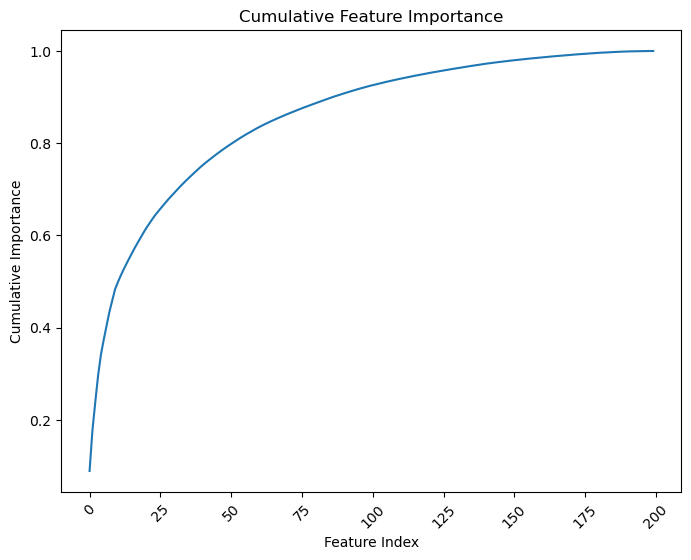

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt



# assume 'feature_importance_df' is your DataFrame with feature importances

# add a new column with cumulative importance
feature_importance_df['Cumulative Importance'] = np.cumsum(feature_importance_df['Importance'])

plt.figure(figsize=(8, 6))
sns.lineplot(x=range(len(feature_importance_df)), y='Cumulative Importance', data=feature_importance_df)
plt.title('Cumulative Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Cumulative Importance')
plt.xticks(rotation=45)
plt.show()

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Custom OneHotEncoder to generate feature names with double underscores
class CustomOneHotEncoder(OneHotEncoder):
    def get_feature_names_out(self, input_features=None):
        """Override method to include double underscore separator"""
        original_names = super().get_feature_names_out(input_features)
        return [name.replace("_", "__", 1) for name in original_names]

def build_pipeline(train_data, most_important_features):
    """
    Build a pipeline with preprocessing and model training, focusing on the most important features.
    """
    # Split data
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)
    
    # Apply feature engineering steps
    X_transformed = _merge_external_data(X_train)
    X_transformed = _add_location_features(X_transformed)
    X_transformed = _encode_dates(X_transformed)

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]

    # All columns in the transformed data
    all_cols = list(X_transformed.columns)

    # Identify other columns
    other_cols = list(set(all_cols) - set(date_cols) - set(categorical_cols))
    
    # Match most_important_features with their transformer groups
    important_date_features = [col for col in most_important_features if "date__" in col]
    important_categorical_features = [col for col in most_important_features if "cat__" in col]
    important_other_features = [col for col in most_important_features if "other__" in col]

    # Extract the original feature names for each group
    date_features_original = list(set([col.split("__")[1] for col in important_date_features]))
    categorical_features_original = list(set([col.split("__")[1] for col in important_categorical_features]))
    other_features_original = list(set([col.split("__")[1] for col in important_other_features]))

    print("the list of feautes to encode")
    print("date features")
    # Use the CustomOneHotEncoder in the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("date", CustomOneHotEncoder(handle_unknown="ignore"), date_features_original),
            ("cat", CustomOneHotEncoder(handle_unknown="ignore"), categorical_features_original),
            ("other", "passthrough", other_features_original)
        ]
    )

      # Create XGBoost with best hyperparameters
    xgb_model = XGBRegressor(
                colsample_bytree=0.9329770563201687,
                gamma=0.10616955533913808,
                learning_rate=0.06454749016213018,
                max_depth=7,
                min_child_weight=1,
                n_estimators=413,
                subsample=0.8099025726528951
            )
    # Build the final pipeline
       # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb_model
    )

    return pipe

In [12]:
important_date_features = [col for col in most_important_features if "date__" in col]
important_categorical_features = [col for col in most_important_features if "cat__" in col]
important_other_features = [col for col in most_important_features if "other__" in col]

# Extract the original feature names for each group
date_features_original = list(set([col.split("__")[1] for col in important_date_features]))
categorical_features_original = list(set([col.split("__")[1] for col in important_categorical_features]))
other_features_original = list(set([col.split("__")[1] for col in important_other_features]))

In [13]:
categorical_features_original

['site_name', 'counter_name']

In [10]:
# Usecase with k important features

train_data = pd.read_parquet("data/train.parquet")
X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

print("Training XGBoost with best hyperparameters with feature hyperparameters")
pipe = build_pipeline(train_data, most_important_features)
pipe.fit(X_train, y_train)

# Make predictions
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(((y_train - y_pred_train) ** 2).mean())
test_rmse = np.sqrt(((y_test - y_pred_test) ** 2).mean())

print(f"\nResults:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training XGBoost with best hyperparameters with feature hyperparameters


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

the list of feautes to encode
date features


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW


Results:
Training RMSE: 0.4129
Test RMSE: 0.4166


In [12]:
feature_importance_df

,Feature,Importance,Cumulative Importance
161,cat__site_name__Totem 64 Rue de Rivoli,0.103714,0.103714
172,other__hour_cos,0.081047,0.184761
151,cat__site_name__Face au 40 quai D'Issy,0.065773,0.250534
137,cat__site_name__18 quai de l'Hôtel de Ville,0.051744,0.302279
90,cat__counter_name__28 boulevard Diderot E-O,0.046505,0.348784
...,...,...,...
66,date__hour__14,0.000114,0.999895
64,date__hour__12,0.000066,0.999961
163,cat__site_name__Totem 85 quai d'Austerlitz,0.000040,1.000000
188,other__high_wind,0.000000,1.000000


In [14]:
def get_k_most_important_feature(df, k):
    most_important_features = df.head(k)["Feature"].tolist()
    return most_important_features


In [15]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

most_important_features = get_k_most_important_feature(feature_importance_df, 120 )


# Usecase with k important features

train_data = pd.read_parquet("data/train.parquet")
X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

print("Training XGBoost with best hyperparameters with feature hyperparameters")
pipe = build_pipeline(train_data, most_important_features)
pipe.fit(X_train, y_train)

# Make predictions
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(((y_train - y_pred_train) ** 2).mean())
test_rmse = np.sqrt(((y_test - y_pred_test) ** 2).mean())

print(f"\nResults:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training XGBoost with best hyperparameters with feature hyperparameters
the list of feautes to encode
date features

Results:
Training RMSE: 0.4126
Test RMSE: 0.4139


In [24]:
pipe

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x000001DEEBD96700>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _add_location_features at 0x000001DEEBD96020>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _encode_dates at 0x000001DEEB8A8180>)),
                ('columntransformer',
                 ColumnTra...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.06454749016213018, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=413, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])


Testing with top 50 important features...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

the list of feautes to encode
date features


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

Training RMSE: 0.4801
Test RMSE: 0.4317

Testing with top 70 important features...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

the list of feautes to encode
date features


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

Training RMSE: 0.4319
Test RMSE: 0.4156

Testing with top 90 important features...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

the list of feautes to encode
date features


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

Training RMSE: 0.4080
Test RMSE: 0.4141

Testing with top 110 important features...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

the list of feautes to encode
date features


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

Training RMSE: 0.4080
Test RMSE: 0.4141

Testing with top 130 important features...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

the list of feautes to encode
date features


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

Training RMSE: 0.4076
Test RMSE: 0.4291

Testing with top 150 important features...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

the list of feautes to encode
date features


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

Training RMSE: 0.4036
Test RMSE: 0.4251

Testing with top 170 important features...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

the list of feautes to encode
date features


C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_22928\3599421236.py:123: FutureW

Training RMSE: 0.4021
Test RMSE: 0.4249


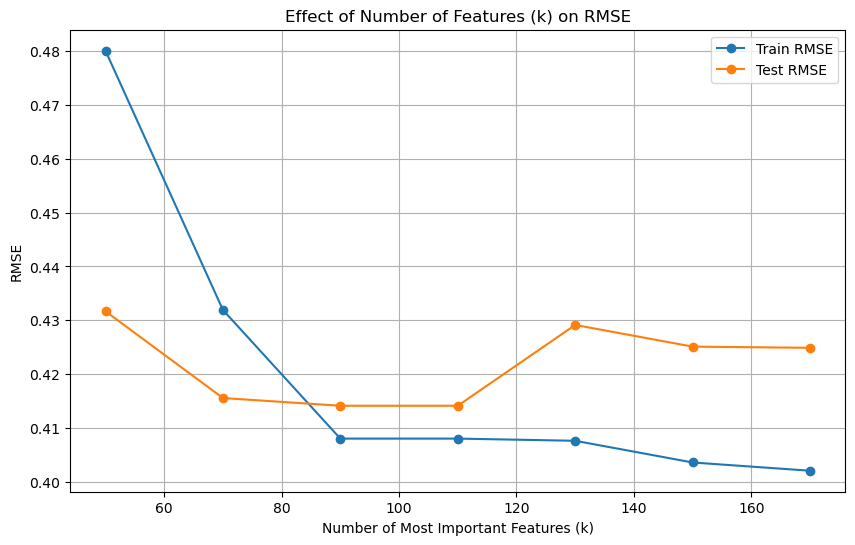

In [ ]:
# How to choose the optimal k

import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Parameters
k_values = list(range(50, 176, 20))
train_rmse_values = []
test_rmse_values = []

# Train and evaluate for each value of k
for k in k_values:
    print(f"\nTesting with top {k} important features...")
    
    # Get the top k most important features
    most_important_features = get_k_most_important_feature(feature_importance_df, k)
    
    # Build pipeline with k most important features
    pipe = build_pipeline(train_data, most_important_features)
    
    # Train the pipeline
    pipe.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    
    # Calculate RMSE
    train_rmse = np.sqrt(((y_train - y_pred_train) ** 2).mean())
    test_rmse = np.sqrt(((y_test - y_pred_test) ** 2).mean())
    
    # Store results
    train_rmse_values.append(train_rmse)
    test_rmse_values.append(test_rmse)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

# Plot the RMSE evolution
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_rmse_values, label="Train RMSE", marker="o")
plt.plot(k_values, test_rmse_values, label="Test RMSE", marker="o")
plt.xlabel("Number of Most Important Features (k)")
plt.ylabel("RMSE")
plt.title("Effect of Number of Features (k) on RMSE")
plt.legend()
plt.grid(True)
plt.show()


# Multimodel selection:



In [16]:

from sklearn.metrics import mean_squared_error
import numpy as np
    

def feature_selection_with_importance(pipe, X_train, y_train, X_test, y_test, k):
    """
    Perform feature selection by keeping the k most important features.
    
    Args:
    - pipe: Trained pipeline.
    - X_train: Training data.
    - y_train: Target for training data.
    - X_test: Test data.
    - y_test: Target for test data.
    - k: Number of most  important features to remove.
    
    Returns:
    - A dictionary with results after removing features.
    """
    # Fit the pipeline to extract feature importances
    pipe.fit(X_train, y_train)
    model = pipe.named_steps["xgbregressor"]
    
    # Extract feature importances
    feature_importances = model.feature_importances_
    feature_names = pipe.named_steps["columntransformer"].get_feature_names_out()
    
    # Combine feature names with their importances
    feature_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)
    
    # Identify k least important features
    most_important_features = feature_importance_df.head(k)["Feature"].tolist()
    
    # Filter out the least important features
    remaining_features = [
        feature for feature in feature_names if feature in most_important_features
    ]
    
    # Update the pipeline with the reduced feature set
    preprocessor = pipe.named_steps["columntransformer"]
    preprocessor.transformers[2] = (
        "other", "passthrough", [
            feature.split('__')[-1] for feature in remaining_features
            if "other" in feature
        ]
    )
    
    # Rebuild and refit the pipeline
    new_pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        pipe.named_steps["xgbregressor"]
    )
    new_pipe.fit(X_train, y_train)
    
    # Evaluate the updated model
    y_pred_train = new_pipe.predict(X_train)
    y_pred_test = new_pipe.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    dict_summary =  {
        "Most_Important_Features": most_important_features,
        "Training_RMSE_After_Removal": train_rmse,
        "Test_RMSE_After_Removal": test_rmse
    }
    return feature_importance_df, dict_summary, most_important_features


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Custom OneHotEncoder to generate feature names with double underscores
class CustomOneHotEncoder(OneHotEncoder):
    def get_feature_names_out(self, input_features=None):
        """Override method to include double underscore separator"""
        original_names = super().get_feature_names_out(input_features)
        return [name.replace("_", "__", 1) for name in original_names]

def build_pipeline(train_data, most_important_features):
    """
    Build a pipeline with preprocessing and model training, focusing on the most important features.
    """
    # Split data
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)
    
    # Apply feature engineering steps
    X_transformed = _merge_external_data(X_train)
    X_transformed = _add_location_features(X_transformed)
    X_transformed = _encode_dates(X_transformed)

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]

    # All columns in the transformed data
    all_cols = list(X_transformed.columns)

    # Identify other columns
    other_cols = list(set(all_cols) - set(date_cols) - set(categorical_cols))
    
    # Match most_important_features with their transformer groups
    important_date_features = [col for col in most_important_features if "date__" in col]
    important_categorical_features = [col for col in most_important_features if "cat__" in col]
    important_other_features = [col for col in most_important_features if "other__" in col]

    # Extract the original feature names for each group
    date_features_original = list(set([col.split("__")[1] for col in important_date_features]))
    categorical_features_original = list(set([col.split("__")[1] for col in important_categorical_features]))
    other_features_original = list(set([col.split("__")[1] for col in important_other_features]))

    print("the list of feautes to encode")
    print("date features")
    # Use the CustomOneHotEncoder in the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("date", CustomOneHotEncoder(handle_unknown="ignore"), date_features_original),
            ("cat", CustomOneHotEncoder(handle_unknown="ignore"), categorical_features_original),
            ("other", "passthrough", other_features_original)
        ]
    )

      # Create XGBoost with best hyperparameters
    xgb_model = XGBRegressor(
                colsample_bytree=0.9329770563201687,
                gamma=0.10616955533913808,
                learning_rate=0.06454749016213018,
                max_depth=7,
                min_child_weight=1,
                n_estimators=413,
                subsample=0.8099025726528951
            )
    # Build the final pipeline
       # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb_model
    )

    return pipe

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Function to evaluate models with scaling where required
def evaluate_models_with_scaling(train_data, most_important_features):
    """
    Test multiple regression models and return their train/test scores as a DataFrame.
    Models requiring scaling will dynamically include scaling in the pipeline.
    """
    # Define models to test
    models = {
        "XGBoost": XGBRegressor(
            colsample_bytree=0.9329770563201687,
            gamma=0.10616955533913808,
            learning_rate=0.06454749016213018,
            max_depth=7,
            min_child_weight=1,
            n_estimators=413,
            subsample=0.8099025726528951
        ),
        #"RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        #"BayesianRidge": BayesianRidge(),
        "CatBoost": CatBoostRegressor(verbose=0),
        #"LightGBM": LGBMRegressor(),
        #"KNN": KNeighborsRegressor(),
        "NeuralNet": MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
    }

    # Models requiring scaling
    models_requiring_scaling = {"BayesianRidge", "KNN", "NeuralNet"}

    # Prepare data
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

    # DataFrame to store results
    results = []

    # Evaluate each model
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        
        # Build pipeline with the current model
        pipe = build_pipeline(train_data, most_important_features)
        
        # Adjust preprocessor to handle missing values in "other" (numeric) features
        preprocessor = pipe.named_steps["columntransformer"]
        
        # Add imputation for missing values in "other"
        updated_transformers = [
            ("date", preprocessor.transformers[0][1], preprocessor.transformers[0][2]),
            ("cat", preprocessor.transformers[1][1], preprocessor.transformers[1][2]),
            ("other", Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),  # Fill NaNs in numeric columns
                ("scaler", preprocessor.transformers[2][1])   # Retain existing transformation (e.g., StandardScaler)
            ]), preprocessor.transformers[2][2])
        ]
        imputed_preprocessor = ColumnTransformer(transformers=updated_transformers)
        pipe.steps[3] = ("preprocessor", imputed_preprocessor)  # Update pipeline

        # Replace the model in the pipeline
        pipe.steps[-1] = ("model", model)
        
        # Train the model
        pipe.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)
        
        # Calculate RMSE
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        print(f"Training RMSE: {train_rmse:.4f}")
        print(f"Test RMSE: {test_rmse:.4f}")
        
        # Store results
        results.append({"Model": model_name, "Train RMSE": train_rmse, "Test RMSE": test_rmse})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df


# Example usage
train_data = pd.read_parquet("data/train.parquet")
most_important_features = get_k_most_important_feature(feature_importance_df, 100)

# Evaluate models
results_df = evaluate_models_with_scaling(train_data, most_important_features)

# Show the DataFrame
results_df


In [ ]:
# cat boost tuned
# catboost_model = CatBoostRegressor(
#         bagging_temperature=0.3745401188473625,
#         depth=8,
#         iterations=370,
#         l2_leaf_reg=8.31993941811405,
#         learning_rate=0.189597545259111,
#         random_strength=0.15601864044243652,
#         subsample=0.7559945203362026,
#         silent=True  # Suppress verbose output
#     )

In [20]:

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


from catboost import CatBoostRegressor
def build_pipeline_catboost(train_data, most_important_features):
    """
    Build a pipeline with preprocessing and model training, focusing on the most important features.
    """
    # Split data
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)
    
    # Apply feature engineering steps
    X_transformed = _merge_external_data(X_train)
    X_transformed = _add_location_features(X_transformed)
    X_transformed = _encode_dates(X_transformed)

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]

    # All columns in the transformed data
    all_cols = list(X_transformed.columns)

    # Identify other columns
    other_cols = list(set(all_cols) - set(date_cols) - set(categorical_cols))
    
    # Match most_important_features with their transformer groups
    important_date_features = [col for col in most_important_features if "date__" in col]
    important_categorical_features = [col for col in most_important_features if "cat__" in col]
    important_other_features = [col for col in most_important_features if "other__" in col]

    # Extract the original feature names for each group
    date_features_original = list(set([col.split("__")[1] for col in important_date_features]))
    categorical_features_original = list(set([col.split("__")[1] for col in important_categorical_features]))
    other_features_original = list(set([col.split("__")[1] for col in important_other_features]))

    print("the list of feautes to encode")
    print("date features")
    # Use the CustomOneHotEncoder in the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("date", CustomOneHotEncoder(handle_unknown="ignore"), date_features_original),
            ("cat", CustomOneHotEncoder(handle_unknown="ignore"), categorical_features_original),
            ("other", "passthrough", other_features_original)
        ]
    )

      # Create XGBoost with best hyperparameters
    catboost_model = CatBoostRegressor(
        bagging_temperature=0.3745401188473625,
        depth=8,
        iterations=370,
        l2_leaf_reg=8.31993941811405,
        learning_rate=0.189597545259111,
        random_strength=0.15601864044243652,
        subsample=0.7559945203362026,
        silent=True  # Suppress verbose output
    )
    # Build the final pipeline
       # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        catboost_model
    )

    return pipe




most_important_features = get_k_most_important_feature(feature_importance_df, 110 )


# Usecase with k important features

train_data = pd.read_parquet("data/train.parquet")
X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

print("Training CatBoost with best hyperparameters with feature hyperparameters")
pipe = build_pipeline(train_data, most_important_features)
pipe.fit(X_train, y_train)

# Make predictions
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(((y_train - y_pred_train) ** 2).mean())
test_rmse = np.sqrt(((y_test - y_pred_test) ** 2).mean())

print(f"\nResults:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training XGBoost with best hyperparameters with feature hyperparameters
the list of feautes to encode
date features

Results:
Training RMSE: 0.4145
Test RMSE: 0.4133


In [19]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

def evaluate_ensemble_and_stacking(train_data, most_important_features):
    """
    Build ensemble (averaging) and stacking models with pipelines and evaluate their performance.
    """
    # Define models
    models = {
        "XGBoost": XGBRegressor(
            colsample_bytree=0.9329770563201687,
            gamma=0.10616955533913808,
            learning_rate=0.06454749016213018,
            max_depth=7,
            min_child_weight=1,
            n_estimators=413,
            subsample=0.8099025726528951
        ),
        "CatBoost": CatBoostRegressor(verbose=0),
        "NeuralNet": MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
    }

    # Prepare data
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

    # Train individual pipelines and store their predictions
    predictions_train = []
    predictions_test = []
    pipelines = []

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")

        
        # Build pipeline with the current model
        pipe = build_pipeline(train_data, most_important_features)
        
        # Adjust preprocessor to handle missing values in "other" (numeric) features
        preprocessor = pipe.named_steps["columntransformer"]
        
        # Add imputation for missing values in "other"
        updated_transformers = [
            ("date", preprocessor.transformers[0][1], preprocessor.transformers[0][2]),
            ("cat", preprocessor.transformers[1][1], preprocessor.transformers[1][2]),
            ("other", Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),  # Fill NaNs in numeric columns
                ("scaler", preprocessor.transformers[2][1])   # Retain existing transformation (e.g., StandardScaler)
            ]), preprocessor.transformers[2][2])
        ]
        imputed_preprocessor = ColumnTransformer(transformers=updated_transformers)
        pipe.steps[3] = ("preprocessor", imputed_preprocessor)  # Update pipeline

        # Replace the model in the pipeline
        pipe.steps[-1] = ("model", model)
        
        # Train the model
        pipe.fit(X_train, y_train)

        # Append predictions and pipeline
        predictions_train.append(y_pred_train)
        predictions_test.append(y_pred_test)
        pipelines.append(pipe)

    # Ensemble: Averaging predictions
    ensemble_pred_train = np.mean(predictions_train, axis=0)
    ensemble_pred_test = np.mean(predictions_test, axis=0)

    # Calculate RMSE for ensemble
    ensemble_train_rmse = np.sqrt(mean_squared_error(y_train, ensemble_pred_train))
    ensemble_test_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred_test))

    print(f"Ensemble Training RMSE: {ensemble_train_rmse:.4f}")
    print(f"Ensemble Test RMSE: {ensemble_test_rmse:.4f}")

    # Stacking: Use predictions as features for a meta-model
    stacking_train_features = np.column_stack(predictions_train)
    stacking_test_features = np.column_stack(predictions_test)

    meta_model = LinearRegression()
    meta_model.fit(stacking_train_features, y_train)

    stacking_pred_train = meta_model.predict(stacking_train_features)
    stacking_pred_test = meta_model.predict(stacking_test_features)

    # Calculate RMSE for stacking
    stacking_train_rmse = np.sqrt(mean_squared_error(y_train, stacking_pred_train))
    stacking_test_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred_test))

    print(f"Stacking Training RMSE: {stacking_train_rmse:.4f}")
    print(f"Stacking Test RMSE: {stacking_test_rmse:.4f}")

    # Collect results
    results = pd.DataFrame({
        "Model": ["Ensemble", "Stacking"],
        "Train RMSE": [ensemble_train_rmse, stacking_train_rmse],
        "Test RMSE": [ensemble_test_rmse, stacking_test_rmse]
    })

    return results


# Example usage
train_data = pd.read_parquet("data/train.parquet")
most_important_features = get_k_most_important_feature(feature_importance_df, 100)

# Evaluate ensemble and stacking
results_df = evaluate_ensemble_and_stacking(train_data, most_important_features)


results_df


Evaluating XGBoost...
the list of feautes to encode
date features

Evaluating CatBoost...
the list of feautes to encode
date features

Evaluating NeuralNet...
the list of feautes to encode
date features
Ensemble Training RMSE: 0.4126
Ensemble Test RMSE: 0.4139
Stacking Training RMSE: 0.4111
Stacking Test RMSE: 0.4143


,Model,Train RMSE,Test RMSE
0,Ensemble,0.412565,0.413873
1,Stacking,0.411132,0.414349


# Time Series Exploration

In [ ]:
# MODEL 13
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    X.loc[:,"dayofyear"] = X["date"].dt.dayofyear
    X.loc[:, "weekofyear"] = X["date"].dt.weekofyear


    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    #external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')


    
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]


     # Select relevant weather features
    relevant_weather_cols = ['date',
        'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol',  # Precipitation & Conditions
        'ff', 'raf10', 'dd',  # Wind
        'vv', 'n', 'u',  # Visibility & Humidity
        'pmer', 'tend'  # Pressure
    ]
    weather_df = weather_data[relevant_weather_cols + cols_to_keep]

    # Missing value handling
    # 1. Rainfall features - forward fill then backward fill, finally fill with 0
    rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
    weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
    # 2. Snow and ground condition - forward fill then most frequent
    weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
    weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
        
    # 3. Wind gust - simple regression based on wind speed
    if weather_data['raf10'].isnull().any():
        from sklearn.linear_model import LinearRegression
        mask = ~weather_data['raf10'].isnull()
        reg = LinearRegression().fit(
                weather_data.loc[mask, ['ff']], 
                weather_data.loc[mask, 'raf10']
            )
        weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
        
    # 4. Cloud cover - forward fill then backward fill
    weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
        
        # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
        
    # Merge with weather data
    X = pd.merge_asof(
            X.sort_values("date"),
            weather_df.sort_values("date"),
            on="date",
            direction="nearest"
        )
        
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)
    return X


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid

def get_estimator(train_data):
    """Create and return the full prediction pipeline."""
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)
    
    X_transformed = _merge_external_data(X_train)
    X_transformed = _add_location_features(X_transformed)
    X_transformed = _encode_dates(X_transformed)

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season", "dayofyear","weekofyear"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]

    all_cols = list(X_transformed.columns)

    other_cols = list(set(all_cols) - set(date_cols) -set(categorical_cols))

    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("other", "passthrough", other_cols)
        ]
    )
    
    # Create XGBoost with best hyperparameters
    xgb_model = XGBRegressor(
                colsample_bytree=0.9329770563201687,
                gamma=0.10616955533913808,
                learning_rate=0.06454749016213018,
                max_depth=7,
                min_child_weight=1,
                n_estimators=413,
                subsample=0.8099025726528951
            )
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb_model
    )
    
    return pipe


# #train_path = Path(__file__).parent / "data" / "train.parquet"
# train_data = pd.read_parquet("data/train.parquet")
# X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

# # # Train XGBoost and predict (this part is already in your code)
# # print("Training XGBoost with best hyperparameters...")
# # pipe = get_estimator(train_data)
# # pipe.fit(X_train, y_train)
# # y_pred_xgb_train = pipe.predict(X_train)
# # y_pred_xgb_test = pipe.predict(X_test)

# # 1. Fit a simple ARIMA model on the training target
# print("Training ARIMA model for seasonal adjustment...")

# y_train_series = pd.Series(y_train, index=X_train["date"])
# y_test_series = pd.Series(y_test, index=X_test["date"])

# arima_model = ARIMA(y_train_series, order=(1, 1, 0))  # Simple ARIMA(p=1, d=1, q=0)
# arima_fit = arima_model.fit()

# # 2. Forecast using ARIMA for the test set
# y_pred_arima_test = arima_fit.forecast(steps=len(y_test_series))

# # # 3. Combine predictions using a weighted ensemble
# # print("Combining predictions using ensemble...")
# # y_pred_ensemble = 0.7 * y_pred_xgb_test + 0.3 * y_pred_arima_test

# # # 4. Evaluate the ensemble model
# # ensemble_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
# # print(f"\nEnsemble RMSE: {ensemble_rmse:.4f}")

# # 5. Evaluate individual models (optional)
# # xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
# arima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_arima_test))
# # print(f"XGBoost RMSE: {xgb_rmse:.4f}")
# print(f"ARIMA RMSE: {arima_rmse:.4f}")

ARIMA not working well because not stationary ( there are seonality in the data) > SARIMA

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# X_train["hour"] = X_train["datetime"].dt.hour
# X_train["weekday"] = X_train["datetime"].dt.weekday
# X_train["day"] = X_train["datetime"].dt.day
# X_train["month"] = X_train["datetime"].dt.month

y_train_series = pd.Series(y_train, index=X_train["date"])
y_test_series = pd.Series(y_test, index=X_test["date"])

# 1. Define SARIMA parameters
seasonal_order = (1, 1, 0, 7)  # (P, D, Q, s) with weekly seasonality (s=7)

# 2. Fit SARIMA model
sarima_model = SARIMAX(y_train_series, order=(1, 1, 0), seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

# 3. Forecast using SARIMA
y_pred_sarima_test = sarima_fit.forecast(steps=len(y_test_series))

# 4. Evaluate SARIMA performance
sarima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sarima_test))
print(f"SARIMA RMSE: {sarima_rmse:.4f}")

# # Combine SARIMA with XGBoost (weights: 0.7 for XGBoost, 0.3 for SARIMA)
# y_pred_ensemble = 0.7 * y_pred_xgb_test + 0.3 * y_pred_sarima_test

# # Evaluate ensemble performance
# ensemble_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
# print(f"Ensemble RMSE: {ensemble_rmse:.4f}")


SARIMA RMSE: 2617.9520


In [ ]:
#train_path = Path(__file__).parent / "data" / "train.parquet"
train_data = pd.read_parquet("data/train.parquet")
train_data["date"] = pd.to_datetime(train_data["date"])
train_data["hour"] = train_data["date"].dt.hour
train_data["weekday"] = train_data["date"].dt.weekday
train_data["day"] = train_data["date"].dt.day
train_data["month"] = train_data["date"].dt.month

X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

y_train_series = pd.Series(y_train, index=X_train["date"])
y_test_series = pd.Series(y_test, index=X_test["date"])


from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA parameters with weekly seasonality (168 hours for weekly cycle)
sarima_model = SARIMAX(
    y_train_series,
    order=(1, 1, 0),  # ARIMA components
    seasonal_order=(1, 1, 0, 168)  # SARIMA seasonal components (7 days = 168 hours)
    #exog=X_train[["hour", "weekday"]]  # Add temporal exogenous variables
)

# Fit and forecast
sarima_fit = sarima_model.fit(disp=False)
y_pred_sarima_test = sarima_fit.forecast(steps=len(y_test))#, exog=X_test[["hour", "weekday"]])

# 4. Evaluate SARIMA performance
sarima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sarima_test))
print(f"SARIMA RMSE: {sarima_rmse:.4f}")

In [3]:
import pandas as pd
from prophet import Prophet
train_data = pd.read_parquet("data/train.parquet")
train_data["date"] = pd.to_datetime(train_data["date"])

X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

y_train_series = pd.Series(y_train, index=X_train["date"])
y_test_series = pd.Series(y_test, index=X_test["date"])

# Prepare data for Prophet
df_train = X_train[["date"]].copy()
df_train["y"] = y_train  # Target variable
df_train.rename(columns={"date": "ds"}, inplace=True)

# Fit Prophet model
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(df_train)

# Forecast
future = X_test[["date"]].copy()
future.rename(columns={"date": "ds"}, inplace=True)
forecast = prophet_model.predict(future)

# Extract predictions
y_pred_prophet = forecast["yhat"]
prophet_rmse = np.sqrt(mean_squared_error(y_test, y_pred_prophet))
print(f"Prophet RMSE: {prophet_rmse:.4f}")


12:20:26 - cmdstanpy - INFO - Chain [1] start processing
12:25:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 1.5249


# Models


In [ ]:
# Let's try possoin loss
objective="count:poisson"

In [65]:
# MODEL 11
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    # external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')


    
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]


     # Select relevant weather features
    relevant_weather_cols = ['date',
        'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol',  # Precipitation & Conditions
        'ff', 'raf10', 'dd',  # Wind
        'vv', 'n', 'u',  # Visibility & Humidity
        'pmer', 'tend'  # Pressure
    ]
    weather_df = weather_data[relevant_weather_cols + cols_to_keep]

    # Missing value handling
    # 1. Rainfall features - forward fill then backward fill, finally fill with 0
    rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
    weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
    # 2. Snow and ground condition - forward fill then most frequent
    weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
    weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
        
    # 3. Wind gust - simple regression based on wind speed
    if weather_data['raf10'].isnull().any():
        from sklearn.linear_model import LinearRegression
        mask = ~weather_data['raf10'].isnull()
        reg = LinearRegression().fit(
                weather_data.loc[mask, ['ff']], 
                weather_data.loc[mask, 'raf10']
            )
        weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
        
    # 4. Cloud cover - forward fill then backward fill
    weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
        
        # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
        
    # Merge with weather data
    X = pd.merge_asof(
            X.sort_values("date"),
            weather_df.sort_values("date"),
            on="date",
            direction="nearest"
        )
        
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)
    return X


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid

def get_estimator(train_data):
    """Create and return the full prediction pipeline."""
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)
    
    X_transformed = _merge_external_data(X_train)
    X_transformed = _add_location_features(X_transformed)
    X_transformed = _encode_dates(X_transformed)

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]

    all_cols = list(X_transformed.columns)

    other_cols = list(set(all_cols) - set(date_cols) -set(categorical_cols))

    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("other", "passthrough", other_cols)
        ]
    )
    
    # Create XGBoost with best hyperparameters
    xgb_model = XGBRegressor(
                colsample_bytree=0.9329770563201687,
                gamma=0.10616955533913808,
                learning_rate=0.06454749016213018,
                max_depth=7,
                min_child_weight=1,
                n_estimators=413,
                subsample=0.8099025726528951
            )
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb_model
    )
    
    return pipe

In [66]:
train_data = pd.read_parquet("data/train.parquet")
X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

print("Training XGBoost with best hyperparameters...")
pipe = get_estimator(train_data)
pipe.fit(X_train, y_train)

# Make predictions
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(((y_train - y_pred_train) ** 2).mean())
test_rmse = np.sqrt(((y_test - y_pred_test) ** 2).mean())

print(f"\nResults:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training XGBoost with best hyperparameters...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\751886291.py:85: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\751886291.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\751886291.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\751886291.py:102: FutureWarning:


Results:
Training RMSE: 0.4014
Test RMSE: 0.4307


In [67]:
# Model 9

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    # external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')


    
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]


     # Select relevant weather features
    relevant_weather_cols = ['date',
        'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol',  # Precipitation & Conditions
        'ff', 'raf10', 'dd',  # Wind
        'vv', 'n', 'u',  # Visibility & Humidity
        'pmer', 'tend'  # Pressure
    ]
    weather_df = weather_data[relevant_weather_cols + cols_to_keep]

    # Missing value handling
    # 1. Rainfall features - forward fill then backward fill, finally fill with 0
    rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
    weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
    # 2. Snow and ground condition - forward fill then most frequent
    weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
    weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
        
    # 3. Wind gust - simple regression based on wind speed
    if weather_data['raf10'].isnull().any():
        from sklearn.linear_model import LinearRegression
        mask = ~weather_data['raf10'].isnull()
        reg = LinearRegression().fit(
                weather_data.loc[mask, ['ff']], 
                weather_data.loc[mask, 'raf10']
            )
        weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
        
    # 4. Cloud cover - forward fill then backward fill
    weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
        
        # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
        
    # Merge with weather data
    X = pd.merge_asof(
            X.sort_values("date"),
            weather_df.sort_values("date"),
            on="date",
            direction="nearest"
        )
        
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)
    return X


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid

def get_estimator(train_data):
    """Create and return the full prediction pipeline."""
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)
    
    X_transformed = _merge_external_data(X_train)
    X_transformed = _add_location_features(X_transformed)
    X_transformed = _encode_dates(X_transformed)

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]

    all_cols = list(X_transformed.columns)

    other_cols = list(set(all_cols) - set(date_cols) -set(categorical_cols))

    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("other", "passthrough", other_cols)
        ]
    )
    
    # Create XGBoost with best hyperparameters
    xgb_model = XGBRegressor(
                        colsample_bytree=0.7799016533479063,
                        gamma=0.1975751180009072,
                        learning_rate=0.28799765973813823,
                        max_depth=9,
                        min_child_weight=6,
                        n_estimators=314,
                        subsample=0.8083337040103294)
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb_model
    )
    
    return pipe

In [68]:
X_transformed = _merge_external_data(X_train)
X_transformed = _add_location_features(X_transformed)
X_transformed = _encode_dates(X_transformed)

X_transformed.columns

C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1360276068.py:86: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1360276068.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1360276068.py:90: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1360276068.py:103: FutureWarn

Index(['counter_name', 'site_name', 'latitude', 'longitude', 'rr1', 'rr3',
       'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol', 'ff', 'raf10',
       'dd', 'vv', 'n', 'u', 'pmer', 'tend', 'temp_celsius', 'is_cold',
       'is_hot', 'high_wind', 'is_raining', 'heavy_rain', 'poor_visibility',
       'high_humidity', 'distance_to_center', 'year', 'month', 'day',
       'weekday', 'hour', 'season', 'is_weekend', 'is_rush_hour',
       'is_working_hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [69]:
# Get date columns for encoding
date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
categorical_cols = ["counter_name", "site_name"]

all_cols = list(X_transformed.columns)

other_cols = list(set(all_cols) - set(date_cols) -set(categorical_cols))


other_cols


['is_hot',
 'temp_celsius',
 'hour_sin',
 'high_wind',
 'heavy_rain',
 'high_humidity',
 'is_raining',
 'pmer',
 'rr6',
 'rr3',
 'distance_to_center',
 'n',
 'is_working_hour',
 'ww',
 'u',
 'is_cold',
 'rr1',
 'is_rush_hour',
 'ht_neige',
 'latitude',
 'rr24',
 'ff',
 'dd',
 'rr12',
 'raf10',
 'vv',
 'poor_visibility',
 'etat_sol',
 'is_weekend',
 'longitude',
 'tend',
 'month_cos',
 'month_sin',
 'hour_cos']

In [70]:
train_data = pd.read_parquet("data/train.parquet")

get_estimator(train_data)

C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1360276068.py:86: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1360276068.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1360276068.py:90: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_23132\1360276068.py:103: FutureWarn

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x0000023F1ECDF420>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _add_location_features at 0x0000023F1ECDCC20>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _encode_dates at 0x0000023F1ECDC720>)),
                ('columntransformer',
                 ColumnTra...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.28799765973813823, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=6, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=314, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [9]:
X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

print("Training XGBoost with best hyperparameters...")
pipe = get_estimator(train_data)
pipe.fit(X_train, y_train)

# Make predictions
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(((y_train - y_pred_train) ** 2).mean())
test_rmse = np.sqrt(((y_test - y_pred_test) ** 2).mean())

print(f"\nResults:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training XGBoost with best hyperparameters...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\1977494089.py:86: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\1977494089.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\1977494089.py:90: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\1977494089.py:103: FutureWarn


Results:
Training RMSE: 0.2873
Test RMSE: 0.4383


In [ ]:
# Model 8
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    # external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')


    
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]


     # Select relevant weather features
    relevant_weather_cols = ['date',
        'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol',  # Precipitation & Conditions
        'ff', 'raf10', 'dd',  # Wind
        'vv', 'n', 'u',  # Visibility & Humidity
        'pmer', 'tend'  # Pressure
    ]
    weather_df = weather_data[relevant_weather_cols + cols_to_keep]

    # Missing value handling
    # 1. Rainfall features - forward fill then backward fill, finally fill with 0
    rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
    weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
    # 2. Snow and ground condition - forward fill then most frequent
    weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
    weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
        
    # 3. Wind gust - simple regression based on wind speed
    if weather_data['raf10'].isnull().any():
        from sklearn.linear_model import LinearRegression
        mask = ~weather_data['raf10'].isnull()
        reg = LinearRegression().fit(
                weather_data.loc[mask, ['ff']], 
                weather_data.loc[mask, 'raf10']
            )
        weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
        
    # 4. Cloud cover - forward fill then backward fill
    weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
        
        # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
        
    # Merge with weather data
    X = pd.merge_asof(
            X.sort_values("date"),
            weather_df.sort_values("date"),
            on="date",
            direction="nearest"
        )
        
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)
    return X


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid

def get_estimator():
    """Create and return the full prediction pipeline."""

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]


    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )
    
    # Create XGBoost with best hyperparameters
    xgb = XGBRegressor()
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb
    )
    
    return pipe

get_estimator()


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x000001F3E7540720>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _add_location_features at 0x000001F3E77139C0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _encode_dates at 0x000001F3E5548A40>)),
                ('columntransformer',
                 ColumnTra...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [2]:
print("Loading and preprocessing data...")
#train_path = Path(__file__).parent / "data" / "train.parquet"

train_data = pd.read_parquet("data/train.parquet")

X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

print("Training XGBoost with best hyperparameters...")
pipe = get_estimator()
pipe.fit(X_train, y_train)

# Make predictions
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(((y_train - y_pred_train) ** 2).mean())
test_rmse = np.sqrt(((y_test - y_pred_test) ** 2).mean())

print(f"\nResults:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Loading and preprocessing data...
Training XGBoost with best hyperparameters...


C:\Users\ibrah\AppData\Local\Temp\ipykernel_28352\1230616226.py:85: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_28352\1230616226.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_28352\1230616226.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_28352\1230616226.py:102: FutureWarn


Results:
Training RMSE: 0.5104
Test RMSE: 0.4694


Loading and preprocessing data...
Training XGBoost with best hyperparameters...

Results:
Training RMSE: 0.4901
Test RMSE: 0.4622


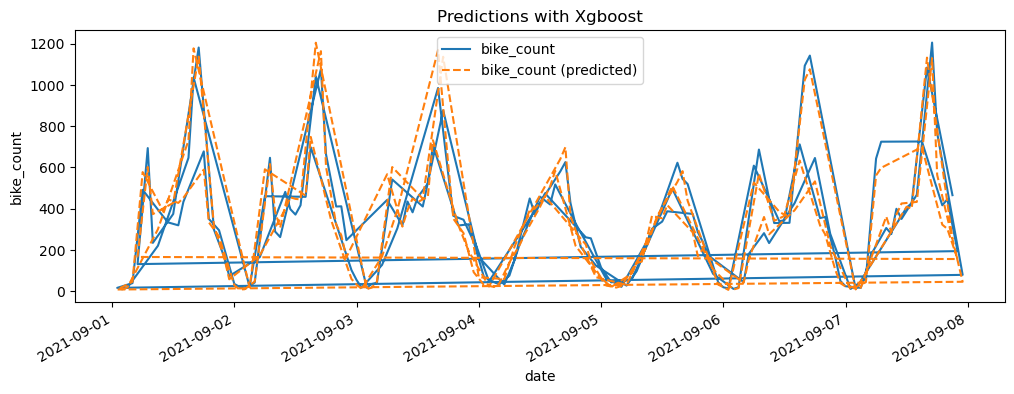

In [ ]:
# model 5  added season variable to the model
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from matplotlib import pyplot as plt
def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    
    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    #external_data_path = Path(__file__).parent / "data" / "external_data.csv"

    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["date", "temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]
    weather_df = weather_data[cols_to_keep]
    
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
    
    # Merge with weather data
    X = pd.merge_asof(
        X.sort_values("date"),
        weather_df.sort_values("date"),
        on="date",
        direction="nearest"
    )
    
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)

def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid
    

def get_estimator():
    """Create and return the full prediction pipeline."""
    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", 
                 "is_weekend", "is_rush_hour", "is_working_hour",
                 "hour_sin", "hour_cos", "month_sin", "month_cos","season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )
    
    # Create XGBoost with best hyperparameters
    xgb = XGBRegressor()
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb
    )
    
    return pipe


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = train_data.drop(["log_bike_count", "bike_count", "counter_id", "site_id", 
                        "counter_technical_id", "coordinates", "counter_installation_date"], 
                       axis=1)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid
    

def main():
    """Main function to train and evaluate the model."""
    print("Loading and preprocessing data...")
    # train_path = Path(__file__).parent / "data" / "train.parquet"
    train_data = pd.read_parquet("data/train.parquet")
    
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

    print("Training XGBoost with best hyperparameters...")
    pipe = get_estimator()
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # Calculate RMSE
    train_rmse = np.sqrt(((y_train - y_pred_train) ** 2).mean())
    test_rmse = np.sqrt(((y_test - y_pred_test) ** 2).mean())

    print(f"\nResults:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

    df_viz = X_test.loc[mask].copy()
    df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
    df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1


    fig, ax = plt.subplots(figsize=(12, 4))
    df_viz = df_viz.sort_values("date")
    df_viz.plot(x="date", y="bike_count", ax=ax)
    df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
    ax.set_title("Predictions with Xgboost")
    ax.set_ylabel("bike_count")


main()

In [ ]:
#Model 6 - Test of xgboost, catboost and lightgbm

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    
    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv(external_data_path, parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["date", "temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]
    weather_df = weather_data[cols_to_keep]
    
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
    
    # Merge with weather data
    X = pd.merge_asof(
        X.sort_values("date"),
        weather_df.sort_values("date"),
        on="date",
        direction="nearest"
    )
    
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)

def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid
    

def get_estimator_xgb():
    """Create and return the full prediction pipeline."""
    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", 
                 "is_weekend", "is_rush_hour", "is_working_hour",
                 "hour_sin", "hour_cos", "month_sin", "month_cos","season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )
    
    # Create XGBoost with best hyperparameters
    xgb = XGBRegressor()
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb
    )
    
    return pipe

def get_estimator_cat():
    """Create and return the full prediction pipeline."""
    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", 
                 "is_weekend", "is_rush_hour", "is_working_hour",
                 "hour_sin", "hour_cos", "month_sin", "month_cos","season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )
    
    # Create CatBoost with best hyperparameters
    cat = CatBoostRegressor()    
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        cat
    )
    
    return pipe 

def get_estimator_lgbm():
    """Create and return the full prediction pipeline."""
    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", 
                 "is_weekend", "is_rush_hour", "is_working_hour",
                 "hour_sin", "hour_cos", "month_sin", "month_cos","season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )
    
    # Create LightGBM with best hyperparameters
    lgbm = LGBMRegressor()
    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        lgbm
    )
    
    return pipe


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = train_data.drop(["log_bike_count", "bike_count", "counter_id", "site_id", 
                        "counter_technical_id", "coordinates", "counter_installation_date"], 
                       axis=1)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid
    

def main():
    """Main function to train and evaluate the model."""
    print("Loading and preprocessing data...")
    train_path = Path(__file__).parent / "data" / "train.parquet"
    train_data = pd.read_parquet(train_path)
    
    X_train, X_test, y_train, y_test = prepare_and_split_data(train_data)

    print("Training XGBoost")
    pipe_xgb = get_estimator_xgb()
    pipe_xgb.fit(X_train, y_train)

    print("Training lightGBM")
    pipe_lgbm = get_estimator_lgbm()
    pipe_lgbm.fit(X_train, y_train)

    print("Training CatBoost")
    pipe_cat = get_estimator_cat()
    pipe_cat.fit(X_train, y_train)

    
    # Make predictions for each model
    predictions = {
        'XGBoost': {'train': pipe_xgb.predict(X_train), 'test': pipe_xgb.predict(X_test)},
        'LightGBM': {'train': pipe_lgbm.predict(X_train), 'test': pipe_lgbm.predict(X_test)},
        'CatBoost': {'train': pipe_cat.predict(X_train), 'test': pipe_cat.predict(X_test)}
    }

    # Calculate RMSE for each model
    rmse = {}
    for model, preds in predictions.items():
        train_rmse = np.sqrt(((y_train - preds['train']) ** 2).mean())
        test_rmse = np.sqrt(((y_test - preds['test']) ** 2).mean())
        rmse[model] = {'train': train_rmse, 'test': test_rmse}

    # Print results
    print("\nResults:")
    for model, scores in rmse.items():
        print(f"{model}:")
        print(f"  Training RMSE: {scores['train']:.4f}")
        print(f"  Test RMSE: {scores['test']:.4f}")
        
if __name__ == "__main__":
    main()

In [ ]:
# test de knn


# Hyperparameter Tuning

In [1]:
# Lets try to tune the model 8

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Model 8
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    # external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')


    
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]


     # Select relevant weather features
    relevant_weather_cols = ['date',
        'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol',  # Precipitation & Conditions
        'ff', 'raf10', 'dd',  # Wind
        'vv', 'n', 'u',  # Visibility & Humidity
        'pmer', 'tend'  # Pressure
    ]
    weather_df = weather_data[relevant_weather_cols + cols_to_keep]

    # Missing value handling
    # 1. Rainfall features - forward fill then backward fill, finally fill with 0
    rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
    weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
    # 2. Snow and ground condition - forward fill then most frequent
    weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
    weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
        
    # 3. Wind gust - simple regression based on wind speed
    if weather_data['raf10'].isnull().any():
        from sklearn.linear_model import LinearRegression
        mask = ~weather_data['raf10'].isnull()
        reg = LinearRegression().fit(
                weather_data.loc[mask, ['ff']], 
                weather_data.loc[mask, 'raf10']
            )
        weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
        
    # 4. Cloud cover - forward fill then backward fill
    weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
        
        # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
        
    # Merge with weather data
    X = pd.merge_asof(
            X.sort_values("date"),
            weather_df.sort_values("date"),
            on="date",
            direction="nearest"
        )
        
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)
    return X


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid




def get_estimator_with_tuning(X_train, y_train):
    """Create and return the tuned prediction pipeline."""
    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )
    
    # Create the pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        XGBRegressor()
    )
    
    # Define parameter space
    param_distributions = {
        'xgbregressor__n_estimators': randint(100, 500),
        'xgbregressor__max_depth': randint(3, 10),
        'xgbregressor__learning_rate': uniform(0.01, 0.3),
        'xgbregressor__subsample': uniform(0.6, 0.4),
        'xgbregressor__colsample_bytree': uniform(0.6, 0.4),
        'xgbregressor__min_child_weight': randint(1, 7),
        'xgbregressor__gamma': uniform(0, 0.5)
    }
    
    # Create TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=20,  # Number of parameter settings sampled
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,  # Use all CPU cores
        verbose=2,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    print("\nBest parameters found:")
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")
    
    print(f"\nBest RMSE: {-random_search.best_score_:.4f}")
    
    return random_search.best_estimator_


In [2]:
# Usage example:
def main():
    """Main function to train and evaluate the model."""
    print("Loading and preprocessing data...")
    
    train_data = pd.read_parquet("data/train.parquet")
    
    X_train, X_valid, y_train, y_valid = prepare_and_split_data(train_data)
    
    print("Training model with hyperparameter tuning...")
    best_model = get_estimator_with_tuning(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = best_model.predict(X_valid)
    rmse = np.sqrt(((y_valid - y_pred) ** 2).mean())
    print(f"\nValidation RMSE: {rmse:.4f}")
    
    return best_model
main()

Loading and preprocessing data...
Training model with hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\4011153719.py:90: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\4011153719.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\4011153719.py:94: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\4011153719.py:107: FutureWarn


Best parameters found:
xgbregressor__colsample_bytree: 0.7799016533479063
xgbregressor__gamma: 0.1975751180009072
xgbregressor__learning_rate: 0.28799765973813823
xgbregressor__max_depth: 9
xgbregressor__min_child_weight: 6
xgbregressor__n_estimators: 314
xgbregressor__subsample: 0.8083337040103294

Best RMSE: 0.9458


C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\4011153719.py:90: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\4011153719.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\4011153719.py:94: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
C:\Users\ibrah\AppData\Local\Temp\ipykernel_17056\4011153719.py:107: FutureWarn


Validation RMSE: 0.4215


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x00000272D9AB16C0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _add_location_features at 0x00000272DA7C0180>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _encode_dates at 0x00000272D6FDC7C0>)),
                ('columntransformer',
                 ColumnTra...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.28799765973813823, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=6, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=314, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [5]:
# Model 9 tuning

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Model 8
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def _encode_dates(X):
    """Encode datetime features."""
    X = X.copy()
    
    # Basic time features
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Add season
    X.loc[:, "season"] = pd.cut(X["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"], include_lowest=True)
    
    # Additional time features
    X.loc[:, "is_weekend"] = (X["weekday"] >= 5).astype(int)
    X.loc[:, "is_rush_hour"] = ((X["hour"].isin([7,8,9]) | X["hour"].isin([17,18,19]))).astype(int)
    X.loc[:, "is_working_hour"] = ((X["hour"] >= 8) & (X["hour"] <= 18)).astype(int)
    
    # Cyclical encoding
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["hour"]/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["hour"]/24)
    X.loc[:, "month_sin"] = np.sin(2 * np.pi * X["month"]/12)
    X.loc[:, "month_cos"] = np.cos(2 * np.pi * X["month"]/12)
    
    return X.drop(columns=["date"])

def _merge_external_data(X):
    """Merge input data with weather data."""
    X = X.copy()
    
    # Load and process weather data
    # external_data_path = Path(__file__).parent / "data" / "external_data.csv"
    weather_data = pd.read_csv("data/external_data.csv", parse_dates=["date"])
    
    # Ensure both dataframes use nanosecond datetime
    X["date"] = pd.to_datetime(X["date"]).astype('datetime64[ns]')
    weather_data["date"] = pd.to_datetime(weather_data["date"]).astype('datetime64[ns]')


    
    
    # Process weather features
    weather_data.loc[:, "temp_celsius"] = weather_data["t"] - 273.15
    weather_data.loc[:, "is_cold"] = (weather_data["temp_celsius"] < 10).astype(int)
    weather_data.loc[:, "is_hot"] = (weather_data["temp_celsius"] > 25).astype(int)
    
    wind_kmh = weather_data["ff"] * 3.6
    weather_data.loc[:, "high_wind"] = (wind_kmh > 20).astype(int)
    
    weather_data.loc[:, "is_raining"] = (weather_data["rr1"] > 0).astype(int)
    weather_data.loc[:, "heavy_rain"] = (weather_data["rr1"] > 5).astype(int)
    
    weather_data.loc[:, "poor_visibility"] = (weather_data["vv"] < 10000).astype(int)
    weather_data.loc[:, "high_humidity"] = (weather_data["u"] > 80).astype(int)
    
    # Keep only necessary columns
    cols_to_keep = ["temp_celsius", "is_cold", "is_hot", "high_wind",
                    "is_raining", "heavy_rain", "poor_visibility", "high_humidity"]


     # Select relevant weather features
    relevant_weather_cols = ['date',
        'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'ww', 'ht_neige', 'etat_sol',  # Precipitation & Conditions
        'ff', 'raf10', 'dd',  # Wind
        'vv', 'n', 'u',  # Visibility & Humidity
        'pmer', 'tend'  # Pressure
    ]
    weather_df = weather_data[relevant_weather_cols + cols_to_keep]

    # Missing value handling
    # 1. Rainfall features - forward fill then backward fill, finally fill with 0
    rain_cols = ['rr1', 'rr3', 'rr6','rr12', 'rr24']
    weather_data[rain_cols] = weather_data[rain_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
    # 2. Snow and ground condition - forward fill then most frequent
    weather_data['ht_neige'] = weather_data['ht_neige'].fillna(method='ffill').fillna(0)
    weather_data['etat_sol'] = weather_data['etat_sol'].fillna(method='ffill').fillna(weather_data['etat_sol'].mode()[0])
        
    # 3. Wind gust - simple regression based on wind speed
    if weather_data['raf10'].isnull().any():
        from sklearn.linear_model import LinearRegression
        mask = ~weather_data['raf10'].isnull()
        reg = LinearRegression().fit(
                weather_data.loc[mask, ['ff']], 
                weather_data.loc[mask, 'raf10']
            )
        weather_data.loc[~mask, 'raf10'] = reg.predict(weather_data.loc[~mask, ['ff']])
        
    # 4. Cloud cover - forward fill then backward fill
    weather_data['n'] = weather_data['n'].fillna(method='ffill').fillna(method='bfill')
        
        # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
        
    # Merge with weather data
    X = pd.merge_asof(
            X.sort_values("date"),
            weather_df.sort_values("date"),
            on="date",
            direction="nearest"
        )
        
    # Sort back to original order and clean up
    X = X.sort_values("orig_index")
    del X["orig_index"]
    
    return X

def _add_location_features(X):
    """Add location-based features."""
    X = X.copy()
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c

    PARIS_CENTER_LAT = 48.8566
    PARIS_CENTER_LON = 2.3522
    X.loc[:, "distance_to_center"] = X.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], 
            PARIS_CENTER_LAT, PARIS_CENTER_LON
        ), axis=1
    )
    
    return X

def prepare_features(data):
    """Prepare features for model input."""
    X = data.drop(["counter_id", "site_id", "counter_technical_id", 
                   "coordinates", "counter_installation_date"], axis=1)
    if "log_bike_count" in X.columns:
        X = X.drop(["log_bike_count", "bike_count"], axis=1)
    return X


def prepare_and_split_data(train_data, validation_days=30):
    """Prepare features and target variables, and split data into train and validation sets."""
    # Prepare features and target

    y = train_data["log_bike_count"].values
    X = prepare_features(train_data)
    
    # Split into train and validation sets
    cutoff_date = X["date"].max() - pd.Timedelta("30 days")
    train_mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[train_mask], X.loc[~train_mask]
    y_train, y_valid = y[train_mask], y[~train_mask]

    return X_train, X_valid, y_train, y_valid

def get_estimator_with_tuning(X_train, y_train):
    """Create and return the tuned prediction pipeline."""
    X_transformed = _merge_external_data(X_train)
    X_transformed = _add_location_features(X_transformed)
    X_transformed = _encode_dates(X_transformed)

    # Get date columns for encoding
    date_cols = ["year", "month", "day", "weekday", "hour", "season"]
    
    # Define categorical columns
    categorical_cols = ["counter_name", "site_name"]

    all_cols = list(X_transformed.columns)

    other_cols = list(set(all_cols) - set(date_cols) -set(categorical_cols))

    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("other", "passthrough", other_cols)
        ]
    )

    # Create XGBoost with best hyperparameters
    xgb_model = XGBRegressor()

    # Create the full pipeline
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        FunctionTransformer(_add_location_features, validate=False),
        FunctionTransformer(_encode_dates, validate=False),
        preprocessor,
        xgb_model
    )
    
    # Define parameter space
    param_distributions = {
        'xgbregressor__n_estimators': randint(100, 500),
        'xgbregressor__max_depth': randint(3, 10),
        'xgbregressor__learning_rate': uniform(0.01, 0.3),
        'xgbregressor__subsample': uniform(0.6, 0.4),
        'xgbregressor__colsample_bytree': uniform(0.6, 0.4),
        'xgbregressor__min_child_weight': randint(1, 7),
        'xgbregressor__gamma': uniform(0, 0.5)
    }
    
    # Create TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=20,  # Number of parameter settings sampled
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,  # Use all CPU cores
        verbose=2,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    print("\nBest parameters found:")
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")
    
    print(f"\nBest RMSE: {-random_search.best_score_:.4f}")
    
    return random_search.best_estimator_
